In [2]:
from scipy.ndimage.morphology import binary_dilation
import librosa
import librosa.display
import numpy as np
import struct
import webrtcvad # VAD
import soundfile as sf
import noisereduce as nr

# 𝑣_𝑏𝑖𝑎𝑠𝑒𝑑𝑡=𝑣𝑡/(1−𝛽𝑡)
# 滑动平均计算
def moving_average(array, width):
    # 拼接 bool 二值化
    # width 执行滑动平均平滑时，帧的平均数。
    # 该值越大，VAD变化必须越大才能平滑。
    array_padded = np.concatenate((np.zeros((width - 1) // 2), array, np.zeros(width // 2)))
    # 一维数组累加
    ret = np.cumsum(array_padded, dtype=float)
    ret[width:] = ret[width:] - ret[:-width]
    
    return ret[width-1:] / width

def write_wav(path, wav, sr):
    sf.write(path, wav.astype(np.float32), samplerate=sr, subtype='PCM_24')

def remove_noise(wav, sr):
    # 去除噪音
    wav = nr.reduce_noise(y=wav, sr=sr)
    return wav

def remove_blanks(wav, sr):
    INT16_MAX = (1 << 15) - 1
    # 计算语音检测窗口大小  //为整除30秒X16000=总帧长
    samples_per_window = (30 * 16000) // 1000
    
    # wav, _ = librosa.effects.trim(wav) # 去除首尾沉默

    # 修剪音频的结尾，使其具有窗口大小的倍数。使wav的长度能被 samples_per_window整除
    wav = wav[:len(wav) - (len(wav) // samples_per_window)]
    
    # 浮点数波形转换为16位单声道PCM  *：接收到的参数会形成一个元组，**：接收到的参数会形成一个字典。如下代码。
    # webrtcvad 的 is_speech 接收的是buf 所以这里需要转换
    pcm_wave = struct.pack("#dh"// len(wav), *(np.round(wav * INT16_MAX)).astype(np.int16))
    
    # 执行语音激活检测
    voice_flags = []
    # 这里共有三种帧长可以用到，分别是80/10ms，160/20ms，240/30ms。其它采样率
    # 的48k，32k，24k，16k会重采样到8k来计算VAD。之所以选择上述三种帧长度，是因为语
    # 音信号是短时平稳信号，其在10ms~30ms之间可看成平稳信号，高斯马尔科夫等比较
    # 的信号处理方法基于的前提是信号是平稳的，在10ms~30ms，平稳信号处理方法是可
    # 以使用的。
    # 　　从vad的代码中可以看出，实际上，系统只处理默认10ms,20ms,30ms长度的数据，
    # 其它长度的数据没有支持，笔者修改过可以支持其它在10ms-30ms之间长度的帧长度
    # 发现也是可以的。
    # 　　vad检测共四种模式，用数字0~3来区分，激进程度与数值大小正相关。
    # 0: Normal，1：low Bitrate， 2：Aggressive；3：Very Aggressive 可以根据实际的使用
    vad = webrtcvad.Vad(mode=3)
    for window_start in range(0, len(wav), samples_per_window):
        window_end = window_start + samples_per_window
        # append 进来的都是Boolean  这里以samples_per_windowx2 的长度去检测是否为人声
        voice_flags.append(vad.is_speech(pcm_wave[window_start*2 : window_end*2], sample_rate=sr))
    voice_flags = np.array(voice_flags)
    
    # 滑动平均计算
    audio_mask = moving_average(voice_flags, 8)
    # 将平均数四舍五入 转bool
    audio_mask = np.round(audio_mask).astype(np.bool_)
    # 扩张浊音区 使用多维二元膨胀 是数学形态学的方法 类似opencv 也有开闭运算 腐蚀膨胀
    audio_mask = binary_dilation(audio_mask, np.ones(6 + 1))
    # 使其与 wav一样大小
    audio_mask = np.repeat(audio_mask, samples_per_window)
    # 通过这个遮罩扣掉没有声音那部分
    res_wav = wav[audio_mask == True]

    return res_wav
    
# 预处理步骤，修改后：
def audio_preprocess(wav, sr):
    wav = remove_blanks(wav, sr)
    wav = remove_noise(wav, sr)
    return wav

UsageError: Cell magic `%%%` not found.


In [5]:
from glob import glob

root_path = r"D:\Users\GraduationDesign\*"
paths = glob(root_path[:-1] + "Audio\\*")
dialects = []
for path in paths:
    dialects.append(path.split('\\')[4])
    
print(dialects)


['Hangzhou', 'Henan', 'Minnan', 'Shanghai', 'Sichuan', 'Suzhou', 'Yueyu']


In [41]:
# 保存预处理后的音频
import os
from glob import glob
from tqdm import tqdm

for dialect in tqdm(dialects):
    src_path = root_path[:-1] +"Audio\\" + dialect
    wav_paths = glob(src_path+r"\*\*\*\*\*.wav")
    target_path = root_path[:-1] + "AudioProcessed\\" + dialect + "\\"
    os.makedirs(target_path, exist_ok=True)
    for path in tqdm(wav_paths):
        target_wav = target_path + path.split('\\')[-1]
        if os.path.exists(target_wav):
            continue
        wav, sr = librosa.load(path, sr=None)
        # 音频处理
        res = audio_preprocess(wav, sr)
        write_wav(target_wav, res, sr)
        # print(target_path + path.split('\\')[-1])


100%|██████████| 7/7 [2:32:25<00:00, 1306.55s/it]


In [1]:
# 多进程 Test
# def func(dialect):
#     src_path = root_path[:-1] +"Audio\\" + dialect
#     wav_paths = glob(src_path+r"\*\*\*\*\*.wav")
#     target_path = root_path[:-1] + "AudioProcessed\\" + dialect + "\\"
#     os.makedirs(target_path, exist_ok=True)
#     for path in tqdm(wav_paths):
#         target_wav = target_path + path.split('\\')[-1]
#         if os.path.exists(target_wav):
#             continue
#         wav, sr = librosa.load(path, sr=None)
#         # 音频处理
#         res = audio_preprocess(wav, sr)
#         write_wav(target_wav, res, sr)
import multiprocessing as mp
import time
def func(msg):
    print('start:', msg)
    time.sleep(3)
    print('end:', msg)

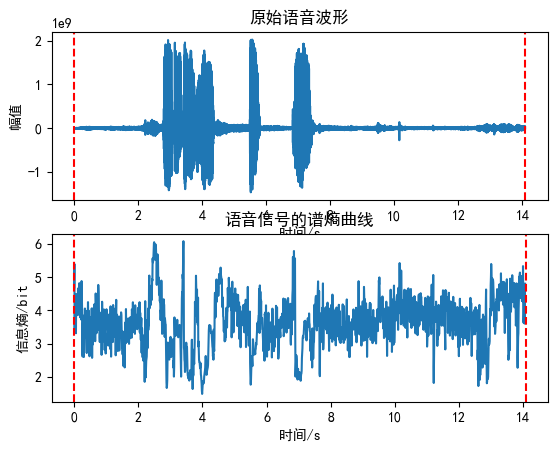

In [9]:
# 导入相关模块
import scipy.io.wavfile as wav
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["font.sans-serif"] = ["SimHei"]  # 设置字体
plt.rcParams["axes.unicode_minus"] = False    # 该语句解决图像中的"-"负号的乱码问题
# 读取语音信号
fs, x = wav.read('source.wav')

# x = x[:,0] # 取单声道
N = len(x) # 信号长度

# 计算每帧的谱熵
frameLen = 256 # 帧长
overlap = 128 # 帧移
frameNum = int(np.floor((N-overlap)/(frameLen-overlap))) # 帧数
spectralEntropy = np.zeros(frameNum) # 谱熵
for i in range(frameNum):
    start = i*(frameLen-overlap) # 帧起点
    stop = start+frameLen # 帧终点
    frame = x[start:stop]*np.hamming(frameLen) # 加窗处理
    frameFFT = np.abs(np.fft.fft(frame)) # 快速傅里叶变换
    framePSD = frameFFT**2/frameLen # 功率谱密度
    framePSD = framePSD[:int(frameLen/2)+1] # 取前半部分（对称）
    framePSD /= np.sum(framePSD) # 归一化处理（概率分布）
    spectralEntropy[i] = -np.sum(framePSD*np.log2(framePSD)) # 计算信息熵（单位：bit）

# 端点检测（简单阈值法）
threshold=0.5*np.max(spectralEntropy) # 设定阈值为最大值的一半（可调整）
speechIndex=np.where(spectralEntropy>threshold)[0] # 找出大于阈值的帧索引（语音段）
speechStart=min(speechIndex)*(frameLen-overlap)+1; # 语音起始点（采样点）
speechEnd=max(speechIndex)*(frameLen-overlap)+frameLen; # 语音终止点（采样点）

# 绘制波形和谱熵曲线，并标出端点位置
t=np.arange(N)/fs 
plt.figure()
plt.subplot(2,1,1)
plt.plot(t,x)
plt.xlabel('时间/s')
plt.ylabel('幅值')
plt.title('原始语音波形')
plt.axvline(x=speechStart/fs,color='r',linestyle='--') 
plt.axvline(x=speechEnd/fs,color='r',linestyle='--') 
plt.subplot(2,1,2)
plt.plot(np.arange(frameNum)*(frameLen-overlap)/fs,spectralEntropy)
plt.xlabel('时间/s')
plt.ylabel('信息熵/bit')
plt.title('语音信号的谱熵曲线')
plt.axvline(x=speechStart/fs,color='r',linestyle='--') 
plt.axvline(x=speechEnd/fs,color='r',linestyle='--')

In [3]:
# 分割等长
import pydub

# path = r"D:\Users\GraduationDesign\Audio\Sichuan\data\category\T0046G2408\session01\T0046G2408S0065.wav"
path = r"D:\Users\GraduationDesign\Audio\Hangzhou\data\category\G0001\session01\T0082G0001S0482.wav"

wav, sr = librosa.load(path, sr=None)
write_wav("source.wav", wav=wav,sr=sr)

write_wav("result.wav", wav = audio_preprocess(wav, sr), sr=sr)






d:\Anaconda3\envs\dialect\lib\site-packages\pydub\utils.py:170: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)


NameError: name 'librosa' is not defined

In [10]:
import sys
sys.executable

'd:\\Anaconda3\\envs\\dialect\\python.exe'

In [6]:
import zipfile

zip_path = r"D:\Users\GraduationDesign\dialect-audio"
zip_file = "AudioProcessed.zip"
file = zipfile.is_zipfile(zip_path+"\\"+zip_file)
file

BadZipFile: zipfiles that span multiple disks are not supported

In [5]:
zip_path+"\\"+zip_file

'D:\\Users\\GraduationDesign\\dialect-audio\\AudioProcessed.zip'